In [1]:
import json

In [2]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Bounds

In [4]:
import pandas as pd

In [5]:
import numpy as np
import torch as th
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import SGConv

[12:25:29Using backend: pytorch
] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/shreyshs/anaconda3/lib/python3.9/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.2.so: cannot open shared object file: No such file or directory


In [6]:
agg_mat = pd.read_pickle('agg.pkl')

In [28]:
agg_dist = pd.read_pickle('agg_distance.pkl')

In [33]:
model = pd.read_pickle('model.pkl')

In [7]:
train_mask, valid_mask, test_mask, graph, node_features, node_labels, n_features, n_labels, check_list = pd.read_pickle('data/sortby_random__divideby_label__seed_19__domainidx_2__checkmethod_agg__nodenumeach_20__dataset_cora__noise_on_feature_no__validnum_500__testnum_1000.pkl')


In [9]:
import pickle

In [14]:
pickle.format_version

'4.0'

In [10]:
pickle.dump(graph, open('cora-dataset/graph.pkl', 'wb'))

In [11]:
pickle.dump(node_features, open('cora-dataset/node_features.pkl', 'wb'))

In [18]:
agg_mat

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0029, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0034, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0034, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0263, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0263, 0.0000]],
       dtype=torch.float64)

In [12]:
pickle.dump(node_labels, open('cora-dataset/node_labels.pkl', 'wb'))

In [15]:
pickle.dump(agg_mat, open('cora-dataset/agg_node_features.pkl', 'wb'))

## Lipchitz parameter c - Not sure how to measure. Setting it to 1/max(em). Look at eq following eq.14 in the paper

In [89]:
c = 1/max(agg_dist.keys())

In [90]:
c

0.0003694126339120798

In [160]:
1/c

2707.0

## N_o = No of Train nodes 

In [38]:
train_mask.sum()

tensor(140)

In [39]:
N0 = 140

## L - No of Layers

In [23]:
L = 1

## alpha - There exists such a value! See Assumption 3 and discussion after Equation 15, it governs probability of undesirable event. So should be set to high value i.e., 1/4

In [40]:
alpha = 0.25 - 1e-6

## delta - Confidence, setting it 0.9

In [41]:
delta = 0.9

## gamma - Margin setting it low value 1e-4

In [159]:
gamma = 1e-4

## K - No of Classes

In [43]:
n_labels

7

In [44]:
K = n_labels

## b - Apparently from a spectral norm inequality. I couldn't locate it in the reference. 
## They didn't even point the equation out!!

In [45]:
b = 1

## C - Upper bound on Frenobius Norm of Wieghts. Setting it to ceil() of the max Frenobius norm

In [52]:
for cp in model.parameters():
    print(cp.shape)

torch.Size([7, 1433])
torch.Size([7])


In [55]:
graph

Graph(num_nodes=2708, num_edges=13264,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [56]:
node_features.shape

torch.Size([2708, 1433])

In [60]:
P = []
for cp in model.parameters():
    P.append(cp.detach().numpy())

In [62]:
W_Fn = (np.sum(np.square(P[0])) + np.sum(np.square(P[1])))**0.5

In [63]:
W_Fn

22.13174732148262

In [65]:
C = 23

In [67]:
agg_mat.shape

torch.Size([2708, 1433])

In [68]:
agg_mat = agg_mat.detach().numpy()

In [70]:
B = np.linalg.norm(agg_mat, axis=1)

In [72]:
B.shape

(2708,)

In [75]:
B0 = np.max(B[train_mask])

In [76]:
B0

0.29193710580065185

In [78]:
node_labels.shape

torch.Size([2708])

In [79]:
max(node_labels)

tensor(6)

In [80]:
K

7

In [122]:
def compute_upper_bound(vi):
    ub = c * K * agg_dist[vi]
    print(ub)
    ub += ((W_Fn*b)/(N0**alpha*(gamma/8)**2)) * (agg_dist[vi]**2)
    print(ub)
    ub += N0**(2*alpha-1)
    print(ub)
    ub += N0**(-2*alpha) * np.log((L*C*2*B[vi])/(delta*gamma))
    print(ub)
    return ub

In [126]:
1/(N0**alpha*(gamma/8)**2)

18605875526339.656

In [123]:
compute_upper_bound(0)

0.0002936810832501355
5311267716334.522
5311267716334.607
5311267716335.918


5311267716335.918

In [94]:
gen_bounds = {}
for vi in agg_dist:
    gen_bounds[vi] = compute_upper_bound(vi)

In [98]:
graph.nodes().numpy()

array([   0,    1,    2, ..., 2705, 2706, 2707])

In [100]:
computes_df = pd.DataFrame(graph.nodes().numpy(), columns=['vertices'])

In [102]:
computes_df['gen_bound'] = computes_df['vertices'].apply(lambda x: gen_bounds[x])

In [103]:
computes_df['epsilon_m'] = computes_df['vertices'].apply(lambda x: agg_dist[x])

In [105]:
maxG = computes_df['gen_bound'].max()
minG = computes_df['gen_bound'].min()

In [108]:
predictions = pd.read_pickle('indices.pkl')

In [110]:
predictions.shape

torch.Size([2708])

In [106]:
computes_df['normalized_gen_bounds'] = computes_df['gen_bound'].apply(lambda x: (x - minG)/(maxG - minG))

In [111]:
computes_df['predictions'] = predictions

In [112]:
computes_df['true_labels'] = node_labels

In [113]:
computes_df['mismatch'] = 1.0 * (computes_df['predictions'] == computes_df['true_labels'])

In [114]:
test_mask

tensor([ True, False, False,  ..., False, False,  True])

In [115]:
computes_df['is_test'] = 1.0 * (test_mask.numpy())

In [117]:
computes_df['is_test'].value_counts()

0.0    1708
1.0    1000
Name: is_test, dtype: int64

<AxesSubplot:title={'center':'normalized_gen_bounds'}, xlabel='[mismatch]'>

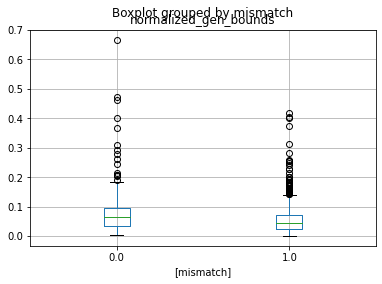

In [119]:
computes_df[computes_df.is_test == 1.0][['normalized_gen_bounds', 'mismatch']].boxplot(by='mismatch')

<AxesSubplot:title={'center':'normalized_gen_bounds'}, xlabel='[mismatch]'>

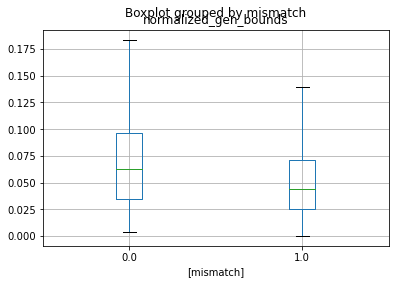

In [120]:
computes_df[computes_df.is_test == 1.0][['normalized_gen_bounds', 'mismatch']].boxplot(by='mismatch', showfliers=False)

In [128]:
len(check_list)

5

In [129]:
test_check_list = {}
for i in range(5):
    gn = len(check_list[i])
    tlist = []
    for j in range(gn):
        if test_mask[check_list[i][j]]:
            tlist.append(check_list[i][j])
    test_check_list[i] = tlist

In [131]:
test_group_df_list = []
for i in range(5):
    for j in test_check_list[i]:
        for k in test_check_list[i]:
            if j != k:
                test_group_df_list.append((i, j, k))

In [135]:
test_group_df = pd.DataFrame(test_group_df_list, columns=['group', 'vi', 'vj'])

In [140]:
test_group_df['has_edge'] = test_group_df.apply(lambda x: graph.has_edge_between(x['vi'], x['vj']) * 1.0, axis=1)

In [145]:
predictions = predictions.numpy()

In [147]:
node_labels = node_labels.numpy()

In [156]:
def is_correlated(x):
    vi = int(x['vi'])
    vj = int(x['vj'])
    if predictions[vi] == node_labels[vi] and predictions[vj] == node_labels[vj]:
        return 1.0
    elif predictions[vi] != node_labels[vi] and predictions[vj] != node_labels[vj]:
        return 1.0
    else:
        return 0.0

In [157]:
test_group_df['has_common'] = test_group_df.apply(is_correlated, axis=1)

In [158]:
test_group_df.groupby(['group', 'has_edge'])['has_common'].mean()

group  has_edge
0      0.0         0.807899
       1.0         0.941176
1      0.0         0.693025
       1.0         0.820000
2      0.0         0.690121
       1.0         0.808511
3      0.0         0.668637
       1.0         0.901961
4      0.0         0.557293
       1.0         0.809524
Name: has_common, dtype: float64